In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Saved metrics: metrics_h24_test_paper.csv


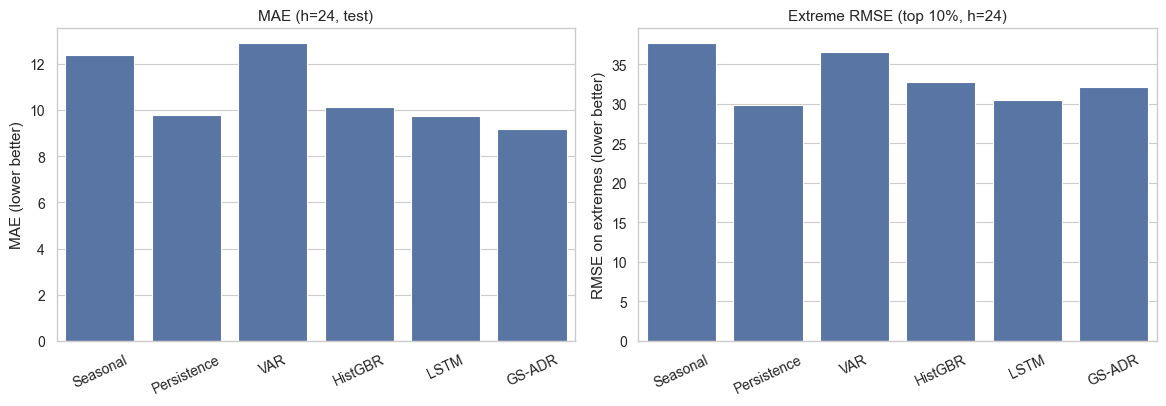

In [2]:
PRED_ALL = "predictions_all_with_pignnpp.csv"
SPLIT = "test"
H = 24

# original model names 
MODEL_ORDER = ["SeasonalNaive","Persistence","VAR(6)","HistGBR","LSTM","PI-GNN++_constraints"]

# display rename
DISPLAY_NAME = {
    "SeasonalNaive": "Seasonal",
    "Persistence": "Persistence",
    "VAR(6)": "VAR",
    "HistGBR": "HistGBR",
    "LSTM": "LSTM",
    "PI-GNN++_constraints": "GS-ADR",
}

EXT_Q = 0.90
SCATTER_PER_MODEL = 15000
RANDOM_SEED = 7

sns.set_theme(style="whitegrid", context="paper", font_scale=1.15)
plt.rcParams.update({
    "savefig.dpi": 300,
    "axes.titleweight": "regular",
})

def rmse(y, yhat):
    y = np.asarray(y); yhat = np.asarray(yhat)
    return float(np.sqrt(np.mean((y - yhat) ** 2)))

def mae(y, yhat):
    y = np.asarray(y); yhat = np.asarray(yhat)
    return float(np.mean(np.abs(y - yhat)))

def metrics_per_model(df_h):
    rows = []
    for m in MODEL_ORDER:
        sub = df_h[df_h["model"] == m]
        if len(sub) == 0:
            continue
        y = sub["y_true"].to_numpy()
        yhat = sub["y_pred"].to_numpy()
        pm10 = sub["pm10_true"].to_numpy()

        thr = np.quantile(y, EXT_Q)
        ext = y >= thr

        rows.append({
            "model": m,
            "model_disp": DISPLAY_NAME.get(m, m),
            "MAE": mae(y, yhat),
            "EXT_RMSE_top10": rmse(y[ext], yhat[ext]) if ext.any() else np.nan,
            "viol_rate": float(np.mean(yhat > pm10)) * 100.0,
        })

    out = pd.DataFrame(rows)
    # keep order
    out["model"] = pd.Categorical(out["model"], categories=[m for m in MODEL_ORDER if m in out["model"].values], ordered=True)
    out = out.sort_values("model")
    out["model_disp"] = pd.Categorical(out["model_disp"], categories=[DISPLAY_NAME.get(m,m) for m in out["model"].cat.categories], ordered=True)
    return out

df = pd.read_csv(PRED_ALL, parse_dates=["datetime"])
df = df[(df["split"] == SPLIT) & (df["horizon_h"].astype(int) == H)].copy()
df = df[df["model"].isin(MODEL_ORDER)].copy()
df["model_disp"] = df["model"].map(lambda x: DISPLAY_NAME.get(x, x))

met = metrics_per_model(df)
met.to_csv(f"metrics_h{H}_{SPLIT}_paper.csv", index=False)
print("Saved metrics:", f"metrics_h{H}_{SPLIT}_paper.csv")

# FIGURE 2: MAE and Extreme RMSE at h=24
fig, axes = plt.subplots(1, 2, figsize=(11.8, 4.2))

sns.barplot(data=met, x="model_disp", y="MAE", ax=axes[0])
axes[0].set_title(f"MAE (h={H}, test)")
axes[0].set_xlabel("")
axes[0].set_ylabel("MAE (lower better)")
axes[0].tick_params(axis="x", rotation=25)

sns.barplot(data=met, x="model_disp", y="EXT_RMSE_top10", ax=axes[1])
axes[1].set_title(f"Extreme RMSE (top 10%, h={H})")
axes[1].set_xlabel("")
axes[1].set_ylabel("RMSE on extremes (lower better)")
axes[1].tick_params(axis="x", rotation=25)

plt.tight_layout()
#plt.savefig(f"Fig2_h{H}_{SPLIT}_2panels.png")
plt.show()

Saved: fig3_policy_metrics_h24_test.csv


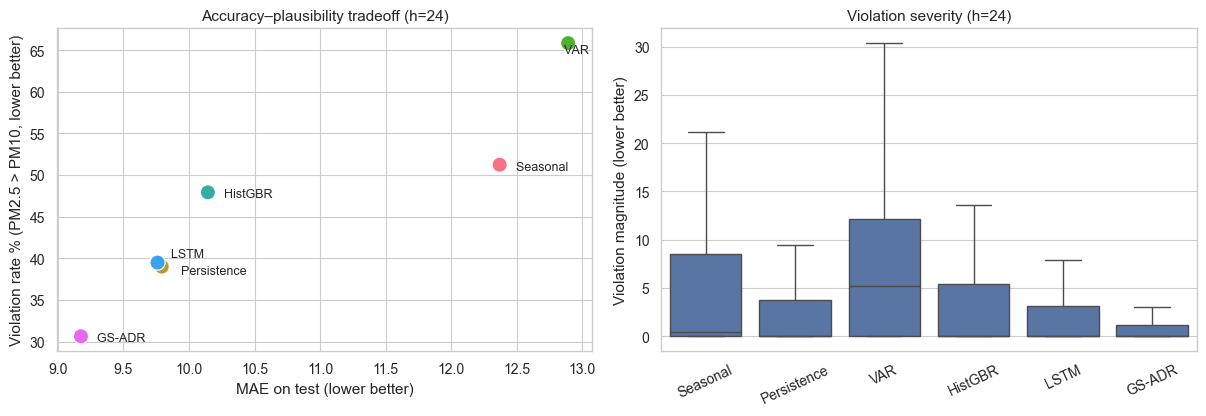

Saved: Fig3_policy_h24_test.png


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text  # Added import only

PRED_ALL = "predictions_all_with_pignnpp.csv"
SPLIT = "test"
H = 24
EXT_Q = 0.90

MODEL_ORDER = ["SeasonalNaive","Persistence","VAR(6)","HistGBR","LSTM","PI-GNN++_constraints"]
DISPLAY_NAME = {
    "SeasonalNaive": "Seasonal",
    "Persistence": "Persistence",
    "VAR(6)": "VAR",
    "HistGBR": "HistGBR",
    "LSTM": "LSTM",
    "PI-GNN++_constraints": "GS-ADR",
}

sns.set_theme(style="whitegrid", context="paper", font_scale=1.15)
plt.rcParams.update({"savefig.dpi": 300})

def rmse(y, yhat):
    y = np.asarray(y); yhat = np.asarray(yhat)
    return float(np.sqrt(np.mean((y - yhat) ** 2)))

def mae(y, yhat):
    y = np.asarray(y); yhat = np.asarray(yhat)
    return float(np.mean(np.abs(y - yhat)))

def viol_rate(yhat, pm10):
    return float(np.mean(yhat > pm10))

# ---- load ----
df = pd.read_csv(PRED_ALL, parse_dates=["datetime"])
df = df[(df["split"] == SPLIT) & (df["horizon_h"].astype(int) == H)].copy()
df = df[df["model"].isin(MODEL_ORDER)].copy()
df["model_disp"] = df["model"].map(lambda x: DISPLAY_NAME.get(x, x))

# summary metrics per model (for tradeoff panel) 
rows = []
for m in MODEL_ORDER:
    sub = df[df["model"] == m]
    if len(sub) == 0:
        continue
    y = sub["y_true"].to_numpy()
    yhat = sub["y_pred"].to_numpy()
    pm10 = sub["pm10_true"].to_numpy()

    thr = np.quantile(y, EXT_Q)
    ext = y >= thr

    rows.append({
        "model": m,
        "model_disp": DISPLAY_NAME.get(m, m),
        "MAE": mae(y, yhat),
        "RMSE_ext_top10": rmse(y[ext], yhat[ext]) if ext.any() else np.nan,
        "viol_rate_pct": 100.0 * viol_rate(yhat, pm10),
        "n": len(sub),
    })

met = pd.DataFrame(rows)
met["model_disp"] = pd.Categorical(
    met["model_disp"],
    categories=[DISPLAY_NAME.get(m, m) for m in MODEL_ORDER if m in met["model"].values],
    ordered=True
)
met.to_csv(f"fig3_policy_metrics_h{H}_{SPLIT}.csv", index=False)
print("Saved:", f"fig3_policy_metrics_h{H}_{SPLIT}.csv")

# violation magnitude distribution frame
df["viol_mag"] = np.maximum(0.0, df["y_pred"] - df["pm10_true"])
df["model_disp"] = pd.Categorical(
    df["model_disp"],
    categories=list(met["model_disp"].cat.categories),
    ordered=True
)

# Vibrant palette
palette = sns.color_palette("husl", n_colors=met["model_disp"].nunique())

# FIG 3: Plausibility tradeoff + Violation magnitude
fig, axes = plt.subplots(1, 2, figsize=(12.2, 4.3))

# (a) Plausibility tradeoff: MAE vs violation % WITH ADJUSTTEXT
sns.scatterplot(
    data=met, x="MAE", y="viol_rate_pct",
    hue="model_disp", palette=palette, s=120, ax=axes[0]
)

# Collect text objects for automatic adjustment
texts = []
for _, r in met.iterrows():
    texts.append(axes[0].text(float(r["MAE"]), float(r["viol_rate_pct"]),
                 "  " + str(r["model_disp"]), va="center", fontsize=9))

# Auto-adjust labels to avoid collisions (minimal parameters)
adjust_text(texts, ax=axes[0])

axes[0].set_title(f"Accuracy–plausibility tradeoff (h={H})")
axes[0].set_xlabel("MAE on test (lower better)")
axes[0].set_ylabel("Violation rate % (PM2.5 > PM10, lower better)")
axes[0].legend().remove()

# (b) Violation magnitude (severity) - unchanged
sns.boxplot(
    data=df, x="model_disp", y="viol_mag",
    ax=axes[1], showfliers=False
)
axes[1].set_title(f"Violation severity (h={H})")
axes[1].set_xlabel("")
axes[1].set_ylabel("Violation magnitude (lower better)")
axes[1].tick_params(axis="x", rotation=25)

plt.tight_layout()
plt.savefig(f"Fig3_policy_h{H}_{SPLIT}.tiff", dpi=600, bbox_inches="tight", pil_kwargs={"compression": "tiff_lzw"})
plt.show()
print("Saved:", f"Fig3_policy_h{H}_{SPLIT}.png")